# Using MobileNetV2 pretrained Model 
The notebook is used to experiment with video classification using 

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [149]:
# tf.enable_eager_execution()

## Reading in data
loading "ucf101" dataset from tensorflow. More info here URL: https://www.crcv.ucf.edu/data/UCF101.php

In [3]:
# ucf101_dataset, ucf101_info = tfds.load(name="ucf101", with_info=True)
# ucf101_train , ucf101_test = ucf101_dataset["train"], ucf101_dataset["test"]
# # assert isinstance(ucf101_info, tf.data.DatasetInfo)
# print(type(ucf101_info))
# assert isinstance(ucf101_train, tf.data.Dataset)
# assert isinstance(ucf101_test, tf.data.Dataset)

SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(ucf101_train, ucf101_validation, ucf101_test), ucf101_info = tfds.load(name="ucf101", split=list(splits),with_info=True)

print('number of training examples:', ucf101_info.splits["train"].num_examples)
print('number of test examples:', ucf101_info.splits["test"].num_examples)
print('number of test examples:', ucf101_info.splits)
print('number of labels:', ucf101_info.features["label"].num_classes)


number of training examples: 9537
number of test examples: 3783
number of test examples: {'test': <tfds.core.SplitInfo num_examples=3783>, 'train': <tfds.core.SplitInfo num_examples=9537>}
number of labels: 101


## Formating data
* normalizing pixels 
* rescaling image to 170 x 170 x 3 as per pare 
* normalize number of frames

In [4]:
IMG_SIZE = 170

def format_videos(dataset):
    dataset["video"] = tf.cast(dataset["video"], tf.float32)
    dataset["video"] = (dataset["video"]/255)
    dataset["video"] = tf.image.resize(dataset["video"], (IMG_SIZE,IMG_SIZE))
    return dataset
    

In [33]:
def select_frame(dataset):
    dataset["video"] = dataset["video"][0] #[0:1]
    return dataset 
    

In [18]:
def convert_to_tuple(dataset):
    x = dataset["video"]
    y = dataset["label"]
    return x,y 

Formating data

In [34]:
train = ucf101_train.map(format_videos)
train = train.map(select_frame)
train = train.map(convert_to_tuple)
validation = ucf101_validation.map(format_videos)
validation = validation.map(select_frame)
validation = validation.map(convert_to_tuple)
test = ucf101_test.map(format_videos)
test = test.map(select_frame)
test = test.map(convert_to_tuple)

shuffling data

In [35]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 2 #1000

In [36]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [37]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 170, 170, 3])

## Single Frame model with MobileNet V2

Creating single frame model from paper

In [28]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

/anaconda2/envs/py37/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [31]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 170, 170, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 171, 171, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 85, 85, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 85, 85, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [38]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [42]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 170, 170, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 171, 171, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 85, 85, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 85, 85, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [61]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [56]:
prediction_layer = tf.keras.layers.Dense(101,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 101)


In [57]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [58]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 101)               129381    
Total params: 2,387,365
Trainable params: 129,381
Non-trainable params: 2,257,984
_________________________________________________________________


In [60]:
len(model.trainable_variables)

2

### training the model

In [65]:
num_train, num_val, num_test = (
  ucf101_info.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [66]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 151s 8s/step - loss: 279.9032 - accuracy: 0.0109


In [67]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 279.90
initial accuracy: 0.01


In [68]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10


W0721 21:45:41.307687 4449158592 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


239/239 [==============================] - 1233s 5s/step - loss: 237.1997 - accuracy: 0.0107 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
239/239 [==============================] - 1193s 5s/step - loss: 233.6337 - accuracy: 0.0107 - val_loss: 246.8436 - val_accuracy: 0.0105
Epoch 3/10
239/239 [==============================] - 1192s 5s/step - loss: 231.8905 - accuracy: 0.0107 - val_loss: 244.1699 - val_accuracy: 0.0105
Epoch 4/10
239/239 [==============================] - 1199s 5s/step - loss: 230.8547 - accuracy: 0.0107 - val_loss: 242.4453 - val_accuracy: 0.0105
Epoch 5/10
239/239 [==============================] - 1221s 5s/step - loss: 230.1757 - accuracy: 0.0107 - val_loss: 241.2339 - val_accuracy: 0.0105
Epoch 6/10
239/239 [==============================] - 1220s 5s/step - loss: 229.6968 - accuracy: 0.0107 - val_loss: 240.3297 - val_accuracy: 0.0105
Epoch 7/10
239/239 [==============================] - 2099s 9s/step - loss: 229.3385 - accuracy: 0.0107 - val_loss: 2

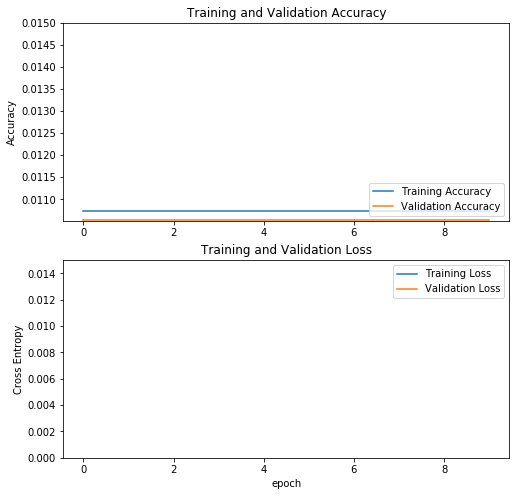

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.015])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.015])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Late fusion Model 